In [1]:
!pip install segmentation_models.pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.3 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=a575206f11db2c0b441480f9068d84732370885bcc2a40962845524c366cdc79
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=a555deb700a414185b466554b10a6dd339d10afb5a90fcde101c14c1e5e21d74
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Attempting uninstall: timm
    Found existing in

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import tensorflow
import albumentations
import cv2
from PIL import Image

import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader  
import torch

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
prefix = '/kaggle/input/covid-segmentation/'

images_radiopedia = np.load(os.path.join(prefix, 'images_radiopedia.npy')).astype(np.float32)
masks_radiopedia = np.load(os.path.join(prefix, 'masks_radiopedia.npy')).astype(np.int8)
images_medseg = np.load(os.path.join(prefix, 'images_medseg.npy')).astype(np.float32)
masks_medseg = np.load(os.path.join(prefix, 'masks_medseg.npy')).astype(np.int8)

test_images_medseg = np.load(os.path.join(prefix, 'test_images_medseg.npy')).astype(np.float32)

In [4]:
def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8, hot_encode=True):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        if hot_encode: 
            ax_image.imshow(image_batch[i,:,:,0], cmap='Greys')
        else: 
            ax_image.imshow(image_batch[i,:,:])
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

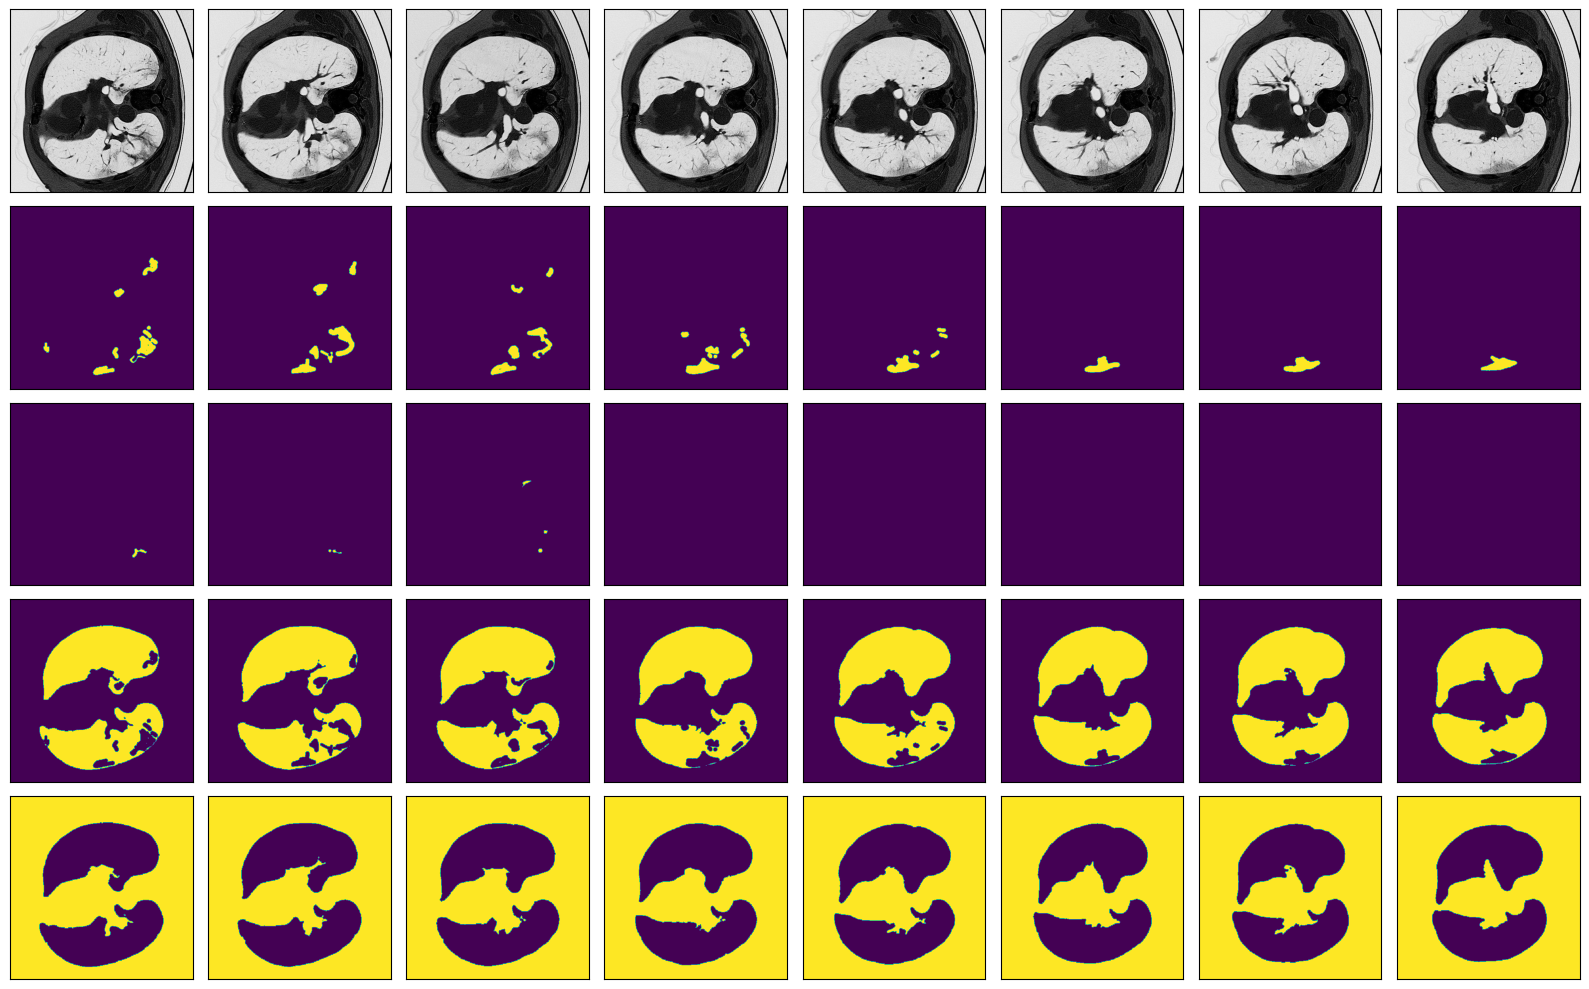

In [5]:
visualize(images_radiopedia[30:], masks_radiopedia[30:])

Hot encoded mask size:  (829, 512, 512, 4)
Paletted mask size: (100, 512, 512)


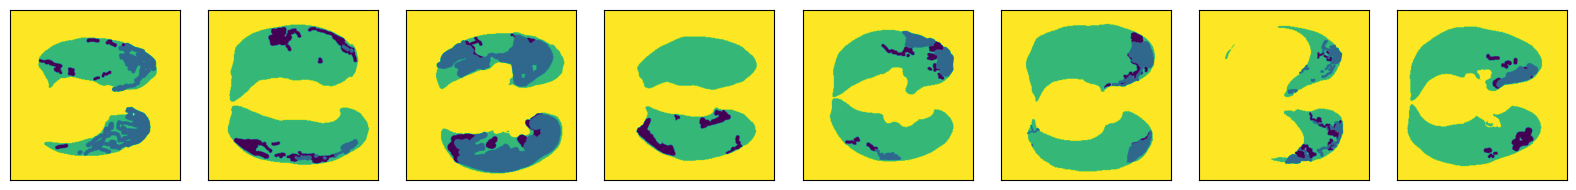

In [6]:
def onehot_to_mask(mask, palette):
    """
    Converts a mask (H, W, K) to (H, W, C)
    """
    x = np.argmax(mask, axis=-1)
    colour_codes = np.array(palette)
    x = np.uint8(colour_codes[x.astype(np.uint8)])
    return x

palette = [[0], [1], [2],[3]]
masks_radiopedia_recover = onehot_to_mask(masks_radiopedia, palette).squeeze()  # shape = (H, W)

masks_medseg_recover = onehot_to_mask(masks_medseg, palette).squeeze()  # shape = (H, W)

print('Hot encoded mask size: ',masks_radiopedia.shape)
print('Paletted mask size:',masks_medseg_recover.shape)

visualize(masks_medseg_recover[30:],hot_encode=False)

In [7]:
def preprocess_images(images_arr, mean_std=None):
    images_arr[images_arr > 500] = 500
    images_arr[images_arr < -1500] = -1500
    min_perc, max_perc = np.percentile(images_arr, 5), np.percentile(images_arr, 95)
    images_arr_valid = images_arr[(images_arr > min_perc) & (images_arr < max_perc)]
    mean, std = (images_arr_valid.mean(), images_arr_valid.std()) if mean_std is None else mean_std
    images_arr = (images_arr - mean) / std
    print(f'mean {mean}, std {std}')
    return images_arr, (mean, std)

images_radiopedia, mean_std = preprocess_images(images_radiopedia)
images_medseg, _ = preprocess_images(images_medseg, mean_std)
test_images_medseg, _ = preprocess_images(test_images_medseg, mean_std)

mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281


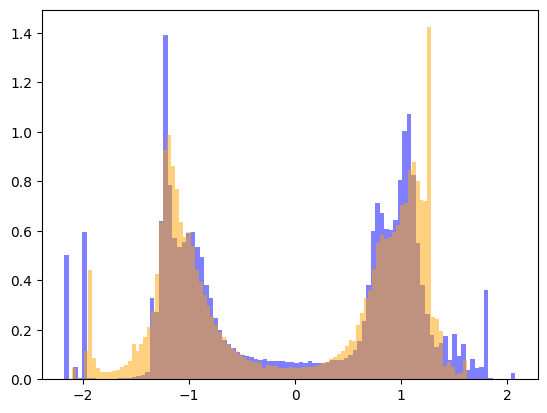

In [8]:
def plot_hists(images1, images2=None):
    plt.hist(images1.ravel(), bins=100, density=True, color='b', alpha=1 if images2 is None else 0.5)
    if images2 is not None:
        plt.hist(images2.ravel(), bins=100, density=True, alpha=0.5, color='orange')
    plt.show();
    
plot_hists(test_images_medseg, images_radiopedia)

In [9]:
masks_radiopedia_recover = onehot_to_mask(masks_radiopedia, palette).squeeze()  # shape = (H, W)
masks_medseg_recover = onehot_to_mask(masks_medseg, palette).squeeze()  # shape = (H, W)


val_indexes, train_indexes = list(range(24)), list(range(24, 100))

train_images = np.concatenate((images_medseg[train_indexes], images_radiopedia))
train_masks = np.concatenate((masks_medseg_recover[train_indexes], masks_radiopedia_recover))
val_images = images_medseg[val_indexes]
val_masks = masks_medseg_recover[val_indexes]

batch_size = len(val_masks)



In [10]:
SOURCE_SIZE = 512
TARGET_SIZE = 224


train_augs = albumentations.Compose([
    albumentations.Rotate(limit=360, p=0.9, border_mode=cv2.BORDER_REPLICATE),
    albumentations.RandomSizedCrop((int(SOURCE_SIZE * 0.75), SOURCE_SIZE), 
                                   TARGET_SIZE, 
                                   TARGET_SIZE, 
                                   interpolation=cv2.INTER_NEAREST),
    albumentations.HorizontalFlip(p=0.5),

])

val_augs = albumentations.Compose([
    albumentations.Resize(TARGET_SIZE, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
])

In [11]:
device = torch.cuda.set_device(0)

class Dataset:   
    def __init__(
            self, 
            images, 
            masks,
            augmentations=None
    ):
        self.images = images
        self.masks = masks
        self.augmentations = augmentations
        self.mean = [0.485]
        self.std = [0.229]
    
    def __getitem__(self, i):
        image = self.images[i]
        mask = self.masks[i]
        
        
        if self.augmentations is not None:
            sample = self.augmentations(image=image, mask=mask)
            
            image, mask = Image.fromarray(np.squeeze(sample['image'], axis=2)), sample['mask']
        
        if self.augmentations is None:
            image = Image.fromarray(image)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        image = t(image)
        mask = torch.from_numpy(mask).long()
    
        return image, mask
    
    def __len__(self):
        return len(self.images)
    
    def tiles(self, image, mask):

        img_patches = image.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches
    
                
train_dataset = Dataset(train_images, train_masks, train_augs)
val_dataset = Dataset(val_images, val_masks, val_augs)       

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#     Converts a segmentation mask (H, W, C) to (H, W, K) where the last dim is a one hot encoding vector, C is usually 1 or 3, and K is the number of class.

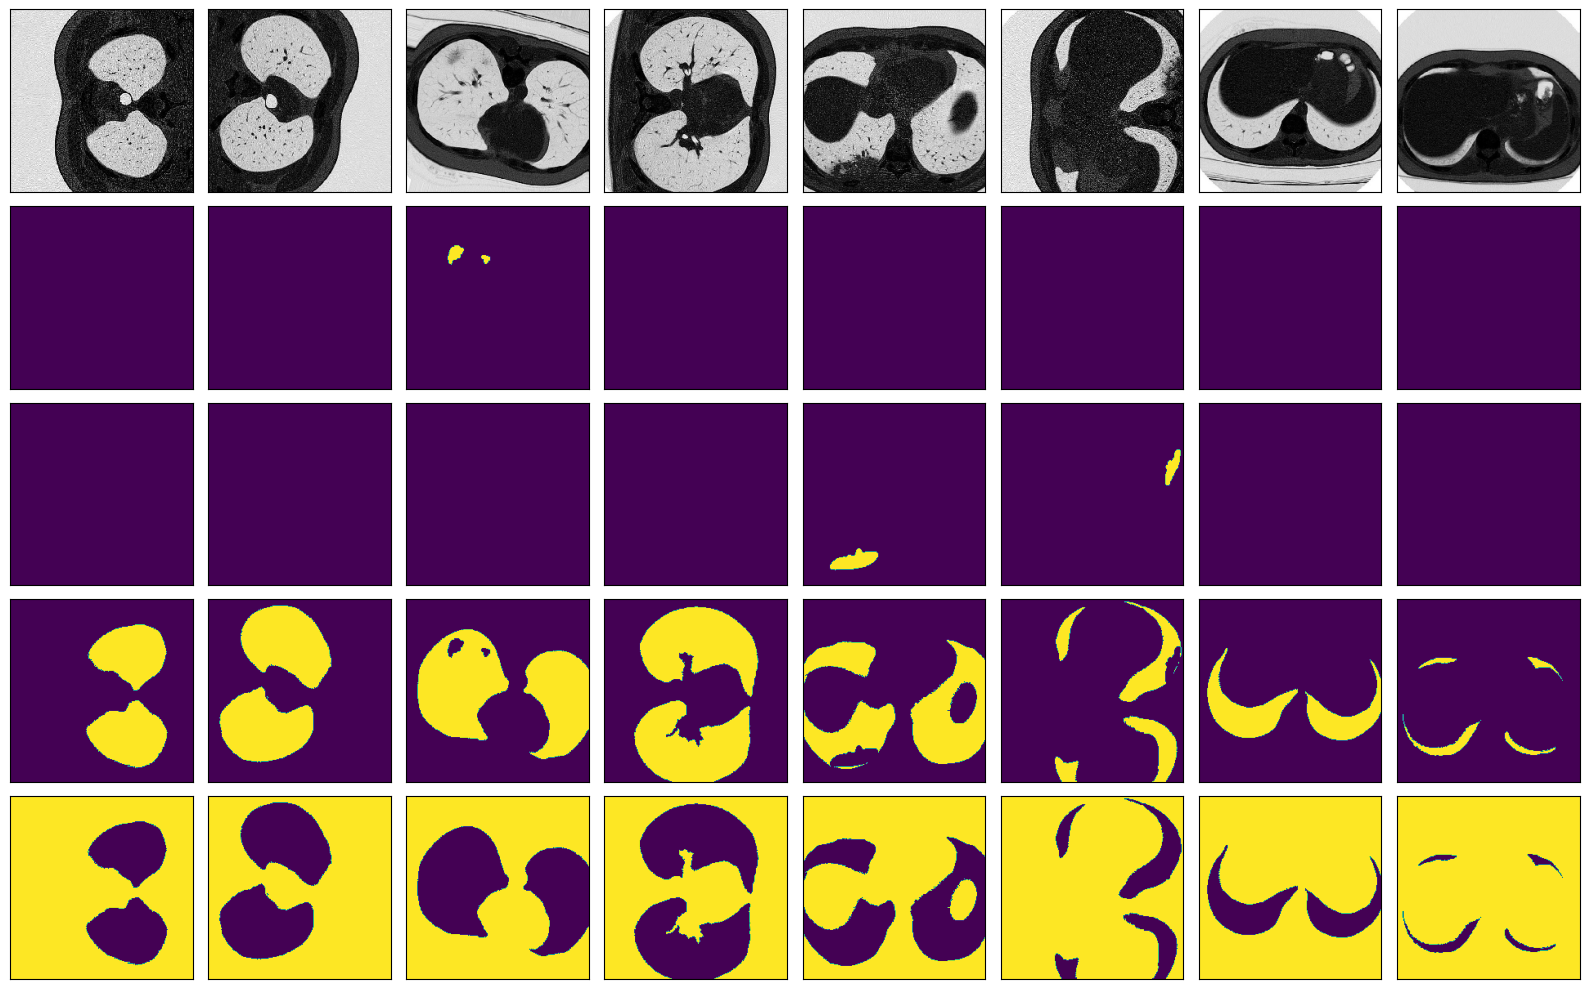

In [12]:
def mask_to_onehot(mask, palette):

    semantic_map = []
    for colour in palette:
        #print('colour',colour)
        equality = np.equal(mask, colour)
        #print('equality',equality)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    return torch.from_numpy(semantic_map)

i,train_data = next(enumerate(train_dataloader))

mask_hot_encoded = mask_to_onehot(torch.unsqueeze(train_data[1],-1).numpy(),palette)
#visualize(torch.unsqueeze(torch.squeeze(train_data[0],1),-1),mask_hot_encoded)
visualize(train_data[0].permute(0, 2, 3,1),mask_hot_encoded)


In [13]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [14]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=4):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [15]:
def iou(pred, gt):
    pred = pred.squeeze().cpu().data.numpy()
    pred = ToLabel(pred)
    gt = gt.squeeze().cpu().data.numpy()
    agg = pred + gt
    i = float(np.sum(agg == 2))
    u = float(np.sum(agg > 0))
    if u == 0:
        result = 1
    else:
        result = i/u
    return result

In [16]:
import segmentation_models_pytorch as smp

# UnetPlusPlus + MobileNetV3

In [17]:
model = smp.UnetPlusPlus('timm-mobilenetv3_small_100',in_channels=1, encoder_weights='imagenet',classes=4, activation=None, encoder_depth=5, decoder_channels=[224, 128, 64, 32, 16])
#decoder_attention_type ='scse'

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_mobilenetv3_small_100-37f49e2b.pth" to /root/.cache/torch/hub/checkpoints/tf_mobilenetv3_small_100-37f49e2b.pth
100%|██████████| 9.78M/9.78M [00:00<00:00, 88.1MB/s]


In [18]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [19]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    device = torch.cuda.set_device(0)
    #torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            
            image = image_tiles.to(device); mask =mask_tiles.to(device);
            #forward
            output = model(image)
            
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data

                    image = image_tiles.to(device); mask =mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'UnetPlusPlus+MobileNetV3.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [20]:
max_lr = 1e-3
epoch = 10
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,steps_per_epoch=len(train_dataloader))

history = fit(epoch, model, train_dataloader, val_dataloader, criterion, optimizer, sched)

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.010 
Epoch:1/10.. Train Loss: 1.287.. Val Loss: 1.010.. Train mIoU:0.157.. Val mIoU: 0.241.. Train Acc:0.401.. Val Acc:0.608.. Time: 7.05m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.010 >> 0.369 
Epoch:2/10.. Train Loss: 0.492.. Val Loss: 0.369.. Train mIoU:0.402.. Val mIoU: 0.416.. Train Acc:0.893.. Val Acc:0.905.. Time: 6.98m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.369 >> 0.260 
Epoch:3/10.. Train Loss: 0.138.. Val Loss: 0.260.. Train mIoU:0.479.. Val mIoU: 0.476.. Train Acc:0.969.. Val Acc:0.918.. Time: 7.00m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.260 >> 0.223 
saving model...
Epoch:4/10.. Train Loss: 0.083.. Val Loss: 0.223.. Train mIoU:0.561.. Val mIoU: 0.549.. Train Acc:0.977.. Val Acc:0.931.. Time: 7.04m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.223 >> 0.223 
Epoch:5/10.. Train Loss: 0.071.. Val Loss: 0.223.. Train mIoU:0.601.. Val mIoU: 0.536.. Train Acc:0.979.. Val Acc:0.931.. Time: 7.00m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.223 >> 0.202 
Epoch:6/10.. Train Loss: 0.061.. Val Loss: 0.202.. Train mIoU:0.615.. Val mIoU: 0.557.. Train Acc:0.981.. Val Acc:0.934.. Time: 7.04m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.202 >> 0.193 
Epoch:7/10.. Train Loss: 0.056.. Val Loss: 0.193.. Train mIoU:0.633.. Val mIoU: 0.576.. Train Acc:0.981.. Val Acc:0.935.. Time: 7.04m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:8/10.. Train Loss: 0.052.. Val Loss: 0.196.. Train mIoU:0.659.. Val mIoU: 0.571.. Train Acc:0.982.. Val Acc:0.935.. Time: 7.09m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.196 >> 0.188 
Epoch:9/10.. Train Loss: 0.051.. Val Loss: 0.188.. Train mIoU:0.680.. Val mIoU: 0.578.. Train Acc:0.983.. Val Acc:0.937.. Time: 7.09m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:10/10.. Train Loss: 0.050.. Val Loss: 0.189.. Train mIoU:0.682.. Val mIoU: 0.580.. Train Acc:0.983.. Val Acc:0.937.. Time: 7.08m
Total time: 70.41 m


In [21]:
torch.save(model, 'Unet-Mobilenet-V3.pt')

In [22]:
df = pd.DataFrame.from_dict(history, orient ='index') 
df.to_excel("output.xlsx")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,370,371,372,373,374,375,376,377,378,379
train_loss,1.286543,0.492060,0.138041,0.083318,0.071169,0.060960,0.056356,0.052048,0.051120,0.049990,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
val_loss,1.010261,0.368893,0.260353,0.222672,0.222622,0.202056,0.193352,0.195783,0.187868,0.188735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
train_miou,0.156586,0.402214,0.479128,0.560517,0.601397,0.615187,0.632702,0.659278,0.679677,0.681930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
val_miou,0.240669,0.415835,0.476400,0.548728,0.536344,0.557054,0.575752,0.570653,0.577633,0.580319,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
train_acc,0.400741,0.892842,0.968725,0.976541,0.979243,0.980521,0.981388,0.982471,0.982964,0.983233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

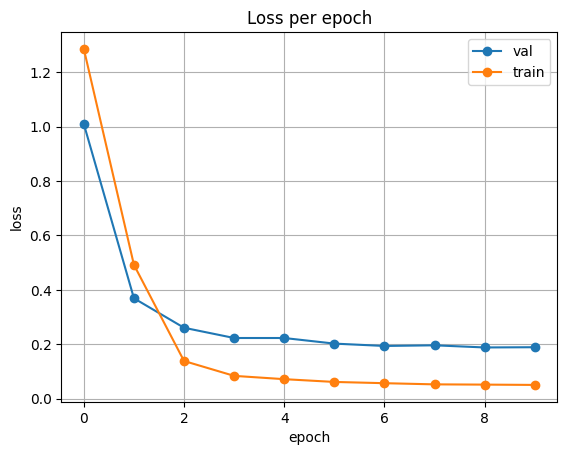

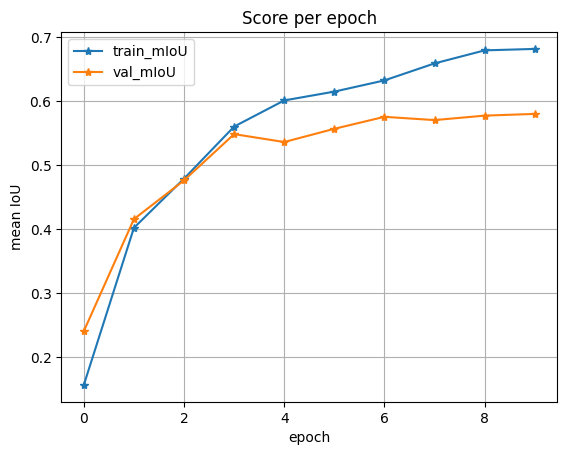

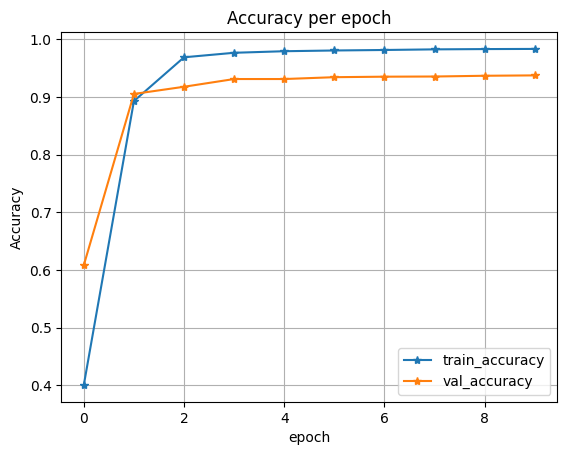

In [24]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [25]:
def predict_image_mask_miou(model, image, mask, mean=[0.485], std=[0.229]):
    model.eval()
    #t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    #image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    
    
    with torch.no_grad():
        
        #image = image.unsqueeze(0)
        #mask = mask.unsqueeze(0)
        
        output = model(image)
        a,b,c,d = output.shape
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score, output.permute(0, 2, 3,1)

In [26]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

#  Converts a segmentation mask (H, W, C) to (H, W, K) where the last dim is a one hot encoding vector, C is usually 1 or 3, and K is the number of class.

In [27]:
def mask_to_onehot(mask, palette):

    semantic_map = []
    for colour in palette:
        equality = np.equal(mask, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    return torch.from_numpy(semantic_map)

In [28]:
%%time
image, mask = next(iter(val_dataloader))
pred_mask, score,output = predict_image_mask_miou(model, image, mask)
semantic_map = mask_to_onehot(torch.unsqueeze(mask,-1).numpy(),palette)

CPU times: user 3.11 s, sys: 354 ms, total: 3.46 s
Wall time: 3.46 s


# yellow is TP, red is FP, green is FN

0.5803193054991789


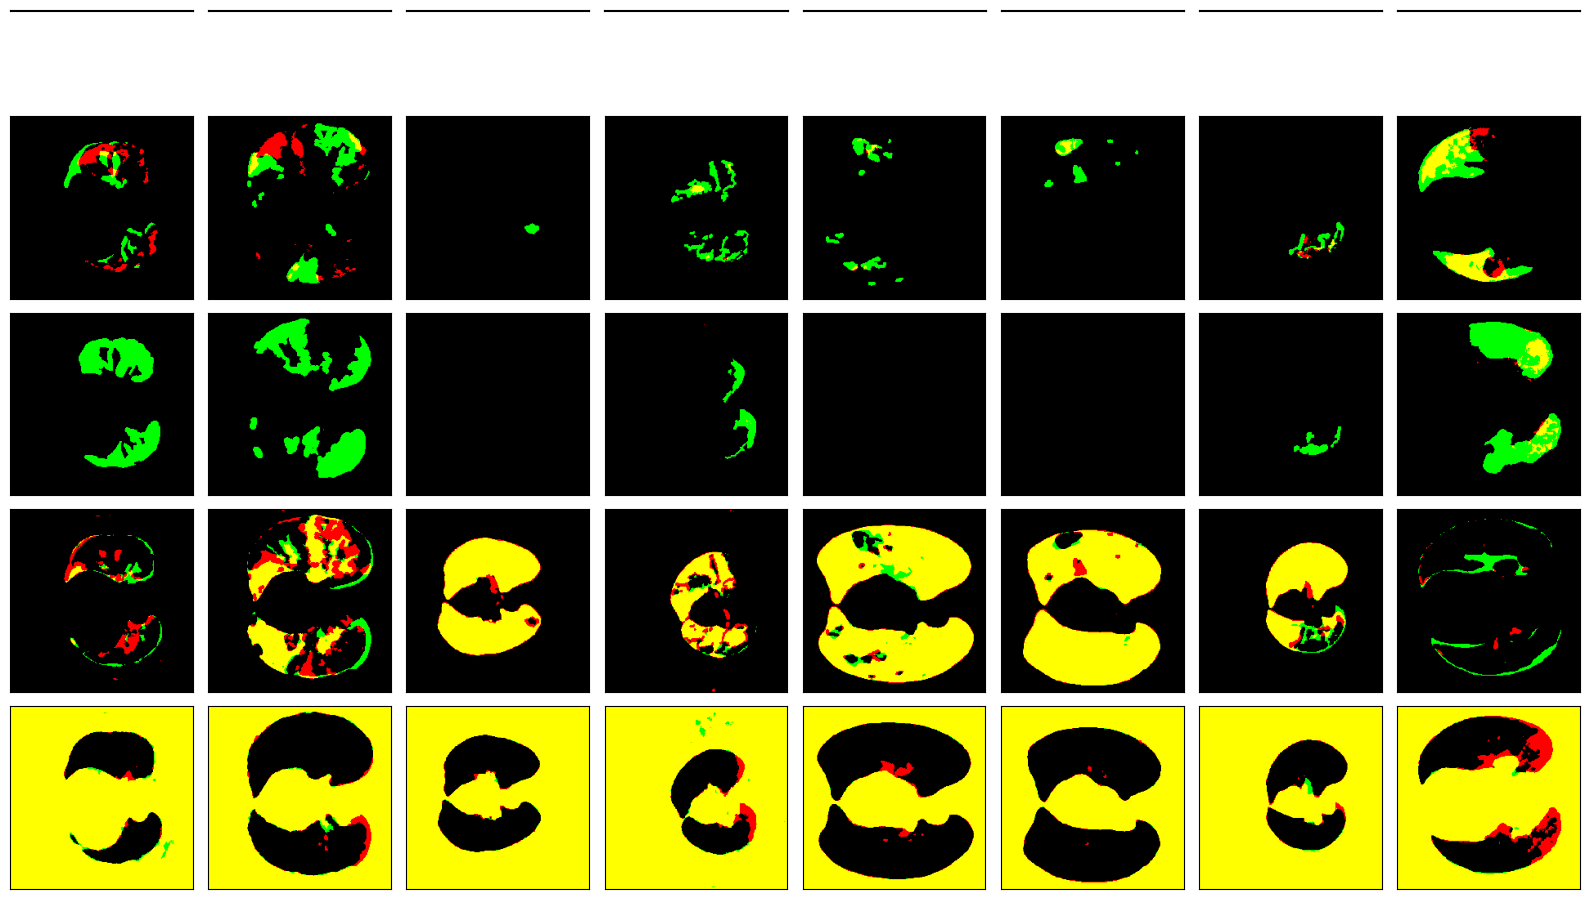

CPU times: user 2.97 s, sys: 174 ms, total: 3.14 s
Wall time: 2.88 s


In [29]:
%%time
print(score)
visualize(image, semantic_map, pred_batch=output)

In [30]:
def miou_score(model, test_set):
    score_iou = []
    for i, data in enumerate(tqdm(test_set)):
        img, mask = data
        pred_mask, score,output = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [31]:
mob_miou = miou_score(model, val_dataloader)
mob_miou

  0%|          | 0/1 [00:00<?, ?it/s]

[0.5803193054991789]

In [32]:
def test_predict(model, image, mean=[0.485], std=[0.229]):
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.eval()
    
    model.to(device); image=image.to(device)
    
    with torch.no_grad():
        output = model(torch.unsqueeze(image,1))
        output = nn.Softmax(dim=1)(output)
    return output.permute(0, 2, 3,1)

torch.Size([10, 224, 224, 1])
(224, 224, 1)
(10, 224, 224, 4)


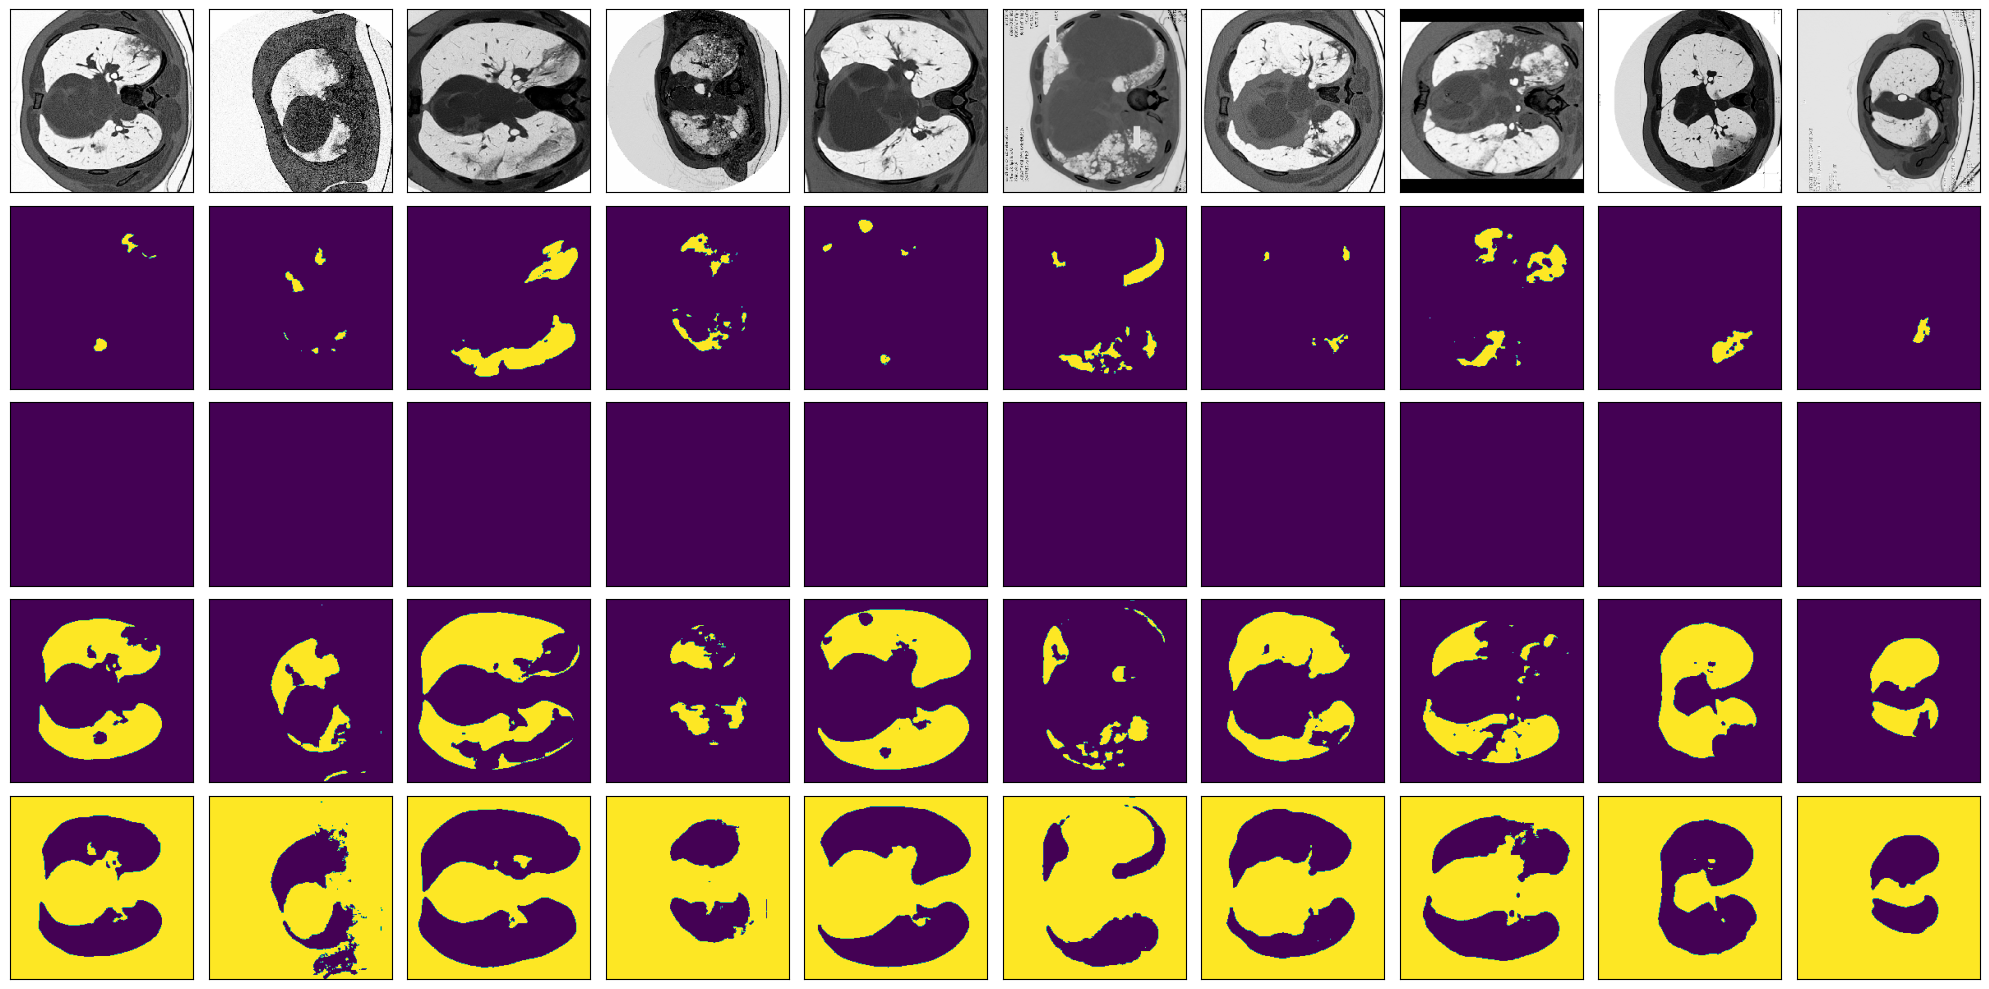

In [33]:
image_batch = np.stack([val_augs(image=img)['image'] for img in test_images_medseg], axis=0)
print(torch.from_numpy(image_batch).shape)
print(image_batch[i].shape)
#output = test_predict(model, torch.from_numpy(image_batch).permute(0, 3, 1,2))
output = np.zeros((10,224,224,4))
for i in range(10):   
    output[i] = test_predict(model, image_batch[i])
print(output.shape)

test_masks_prediction = output > 0.5
#print(test_masks_prediction)
visualize(image_batch, test_masks_prediction, num_samples=len(test_images_medseg))